In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dolfin import *
import numpy as np

In [3]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import ulfy
from dolfin import (
    CompiledSubDomain,
    Constant,
    Function,
    FunctionSpace,
    MeshFunction,
    Point,
    RectangleMesh,
    UnitSquareMesh,
    div,
    grad,
    inner,
)


from multirat.parameters import to_constant
from multirat.multicompartment import (pressure_functionspace, process_boundaries_multicompartment, solve_timestep, solve_solute)
from multirat.boundary import DirichletBoundary, RobinBoundary
from multirat.meshprocessing import Domain
from multirat.utils import assign_mixed_function
from multirat.mms import *
from multirat.computers import BaseComputer
from multirat.timekeeper import TimeKeeper

In [4]:
degree = 4
normals = {1: Constant((-1, 0)), 2: Constant((1, 0)), 3: Constant((0, -1)), 4: Constant((0, 1))}
subdomains = {
    1: CompiledSubDomain("near(x[0], -1)"),
    2: CompiledSubDomain("near(x[0], 1)"),
    3: CompiledSubDomain("near(x[1], -1)"),
    4: CompiledSubDomain("near(x[1], 1)"),
}

params = mms_parameters()
phi, D, K, G, L = to_constant(
    params,
    "porosity",
    "effective_diffusion",
    "hydraulic_conductivity",
    "convective_solute_transfer",
    "diffusive_solute_transfer",
)


# Time
dt = 0.1
endtime = 1.0
compartments = ["pa", "pc"]#, "pv"]
a = {"e": 0.25, "pa": -1.0, "pc": -0.5, "pv": -0.2}
ap = defaultdict(lambda: -1.0)
p0 = defaultdict(lambda: 2.0)

p = {j: mms_quadratic(ap[j], p0[j]) for j in compartments}
time = Constant(0.0)
c = {j: mms_solute_quadratic(a[j], T=endtime) for j in compartments} # Sympy forms
f = solute_sources(c, p, time, K, phi, D, L, G, degree)
c_expr = {j: expr(c[j], degree=degree, t=time) for j in compartments}
boundaries = {j: mms_dirichlet_boundary(c[j], degree=degree, t=time) for j in compartments}

In [5]:
from multirat.computers import BaseComputer
from multirat.timekeeper import TimeKeeper

In [6]:
class ErrorComputer(BaseComputer):
    def __init__(self, c_expr, compartments):
        super().__init__({"errornorm": lambda c: multicomp_errornorm(c_expr, c, compartments, "H1")})

[autoreload of multirat.computers failed: Traceback (most recent call last):
  File "/home/jorgen/programs/miniconda3/envs/multirat/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/jorgen/programs/miniconda3/envs/multirat/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/jorgen/programs/miniconda3/envs/multirat/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/jorgen/programs

[=================== ]    0.0min / 0.0  min
[=================== ]    0.0min / 0.0  min
[=================== ]    0.0min / 0.0  min
[=================== ]    0.0min / 0.0  min


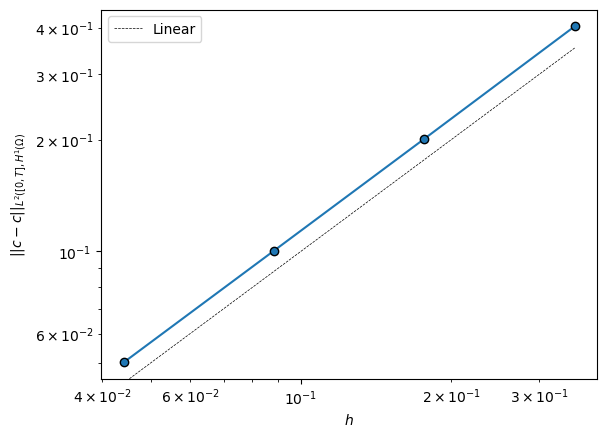

In [14]:
# degree = 4
subdomains = {
    1: CompiledSubDomain("near(x[0], -1)"),
    2: CompiledSubDomain("near(x[0], 1)"),
    3: CompiledSubDomain("near(x[1], -1)"),
    4: CompiledSubDomain("near(x[1], 1)"),
}

params = mms_parameters()
phi, D, K, G, L = to_constant(
    params,
    "porosity",
    "effective_diffusion",
    "hydraulic_conductivity",
    "convective_solute_transfer",
    "diffusive_solute_transfer",
)
time = TimeKeeper(dt=0.1, endtime=1.0)
compartments = ["pa", "pc", "pv"]

# Pressures in sympy format.
ap = {"pa": -1.0, "pc": -0.5, "pv": 0.8}
p0 = {"pa": 1.0, "pc": 0.5, "pv": 0.0}
p_sym = {j: mms_quadratic(ap[j], p0[j]) for j in compartments}

# Concentrations in sympy format.
ac = {"pa": -1.0, "pc": -0.5, "pv": -0.2}
c = {j: mms_solute_quadratic(ac[j], T=endtime) for j in compartments}

# Define solute sources and expressions for sympy represnetations.
time = TimeKeeper(dt, endtime)
f = solute_sources(c, p_sym, time, K, phi, D, L, G, degree)
c_expr = {j: expr(c[j], degree=degree, t=time) for j in compartments}
p_expr = {j: expr(p_sym[j], degree=degree) for j in compartments}

# Define boundary conditions
boundaries = {j: mms_dirichlet_boundary(c[j], degree=degree, t=time) for j in compartments}


E = []
hvec = []
for N in [3, 4, 5, 6]:
    # Setup problem
    time.reset()
    domain = mms_domain(2**N, subdomains)
    V = pressure_functionspace(domain.mesh, 1, compartments)
    p = assign_mixed_function(p_expr, V, compartments)
    C0 = assign_mixed_function(c_expr, V, compartments)
    computer = ErrorComputer(c_expr, compartments)
    # Solve Problem
    solve_solute(C0, p, time, domain, V, compartments, boundaries, params, source=f, computer=computer)
    # Compute error
    temporal_error = np.sqrt(trapezoid_internal(computer["errornorm"] ** 2, time.dt))
    E.append(temporal_error)
    hvec.append(domain.mesh.hmax())
hvec, E = np.array(hvec), np.array(E)

savepath = (Path() / "../results/mms").resolve()
savepath.mkdir(exist_ok=True)

plt.figure()
plt.loglog(hvec, E, "-o", markeredgecolor='k')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.autoscale(False)
plt.loglog(hvec, hvec, 'k--', lw=0.5, label="Linear")
plt.ylim(ylim)

plt.xlabel("$h$")
plt.ylabel(r"$||c - c||_{L^2([0, T], H^1(\Omega)}$")
plt.legend()
plt.savefig(savepath / "convergence-concentration.png")
plt.show()

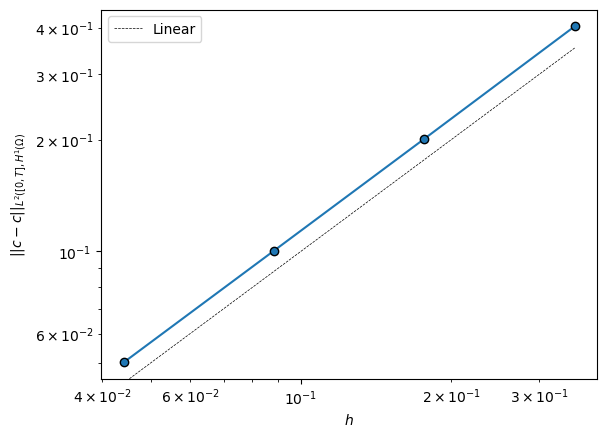

In [15]:
savepath = (Path() / "../results/mms").resolve()
savepath.mkdir(exist_ok=True)

plt.figure()
plt.loglog(hvec, E, "-o", markeredgecolor='k')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.autoscale(False)
plt.loglog(hvec, hvec, 'k--', lw=0.5, label="Linear")
plt.ylim(ylim)

plt.xlabel("$h$")
plt.ylabel(r"$||c - c||_{L^2([0, T], H^1(\Omega)}$")
plt.legend()
plt.savefig(savepath / "convergence-concentration.png")
plt.show()

In [16]:
print("h_i / h_i+1 \t E_i / E_i+1 \t\t log(E_i/E_i+1) / log(h_i / h_i+1)")
print("-" * 80)

for i in range(len(E) - 1):
    print(hvec[i] / hvec[i+1], "\t\t", E[i] / E[i+1], "\t", np.log(E[i] / E[i+1]) / np.log(hvec[i] / hvec[i+1]))

h_i / h_i+1 	 E_i / E_i+1 		 log(E_i/E_i+1) / log(h_i / h_i+1)
--------------------------------------------------------------------------------
2.0 		 2.01010981363182 	 1.0072743189437403
2.0 		 2.0025880290185785 	 1.0018656614790433
2.0 		 2.0006513022948966 	 1.0004697388141421
